In [146]:
try:
    import luas
except ImportError:
    !git clone https://github.com/markfortune/luas.git
    %cd luas
    %pip install .
    %cd ..

try:
    import jaxoplanet
except ImportError:
    %pip install -q jaxoplanet

try:
    import pymc
except ImportError:
    %pip install -q pymc
    
try:
    import corner
except ImportError:
    %pip install -q corner

(pymc_example)=

# PyMC Example: Transmission Spectroscopy

*NOTE: This tutorial notebook is currently in development. Expect significant changes in the future*

This notebook provides to tutorial on how to use ``PyMC`` to perform spectroscopic transit light curve fitting. We will first go through how to generate transit light curves in ``JAX``, then we will create synthetic noise which will be correlated in both wavelength and time. Finally we will use ``PyMC`` to fit the noise contaminated light curves and recover the input transmission spectrum.

In [147]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os.path
import logging
from jaxoplanet.orbits import KeplerianOrbit
from jaxoplanet.light_curves import QuadLightCurve
import arviz as az
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# This helps give more information on what PyMC is doing during inference
logging.getLogger().setLevel(logging.INFO)

# Running this at the start of the runtime ensures jax uses 64-bit floating point numbers
# as jax uses 32-bit by default
jax.config.update("jax_enable_x64", True)


First we will use [jaxoplanet](https://github.com/exoplanet-dev/jaxoplanet) which has its own documentation and tutorials [here](https://jax.exoplanet.codes/en/latest/).

First let's create a single light curve with quadratic limb darkening. We will use the ``transit_light_curve`` function from ``luas.exoplanet`` which is included here for convenience:

In [148]:
def transit_light_curve(par, t):
    """Uses the package `jaxoplanet <https://github.com/exoplanet-dev/jaxoplanet>`_ to calculate
    transit light curves using JAX assuming quadratic limb darkening and a simple circular orbit.
    
    This particular function will only compute a single transit light curve but JAX's vmap function
    can be used to calculate the transit light curve of multiple wavelength bands at once.
    
    Args:
        par (PyTree): The transit parameters stored in a PyTree/dictionary (see example above).
        t (JAXArray): Array of times to calculate the light curve at.
            
    Returns:
        JAXArray: Array of flux values for each time input.
        
    """
    
    light_curve = QuadLightCurve.init(u1=par["u1"], u2=par["u2"])
    orbit = KeplerianOrbit.init(
        time_transit=par["T0"],
        period=par["P"],
        semimajor=par["a"],
        impact_param=par["b"],
        radius=par["rho"],
    )
    
    flux = (par["Foot"] + 24*par["Tgrad"]*(t-par["T0"]))*(1+light_curve.light_curve(orbit, t)[0])
    
    return flux

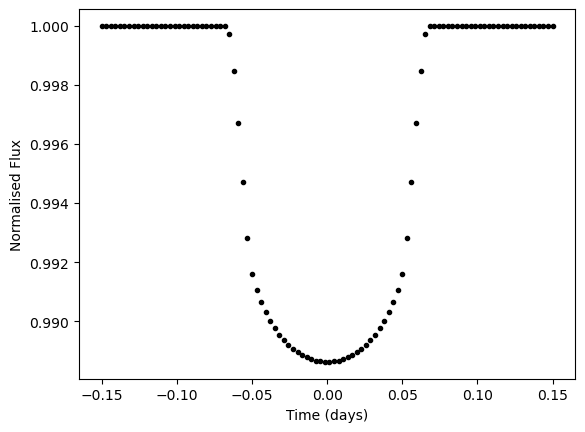

In [149]:
from luas.exoplanet import transit_light_curve

# Let's use the literature values used in Gibson et al. (2017) to start us off
mfp = {
    "T0":0.,       # Central transit time
    "P":3.4,  # Period (days)
    "a":8.,      # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1, # Radius ratio rho aka Rp/R*
    "b":0.5,     # Impact parameter
    "u1":0.5,    # First quadratic limb darkening coefficient
    "u2":0.1,    # Second quadratic limb darkening coefficient
    "Foot":1.,     # Baseline flux out of transit
    "Tgrad":0.     # Gradient in baseline flux (hrs^-1)
}

# Generate 100 evenly spaced time points (in units of days)
N_t = 100
x_t = jnp.linspace(-0.15, 0.15, N_t)

plt.plot(x_t, transit_light_curve(mfp, x_t), "k.")
plt.xlabel("Time (days)")
plt.ylabel("Normalised Flux")
plt.show()

Now we want to take our ``jax`` function which has been written to generate a 1D light curve in time and instead create separate light curves in each wavelength. We also will want to share some parameters between light curves (e.g. impact parameter b, system scale a/Rs) while varying other parameters for each wavelength (e.g. radius ratio Rp/Rs).

We could of course write a for loop but for loops can be slow to compile with ``jax``. A much more efficient option is to make use of ``jax.vmap`` function which allows us to "vectorise" our function from 1D to 2D:

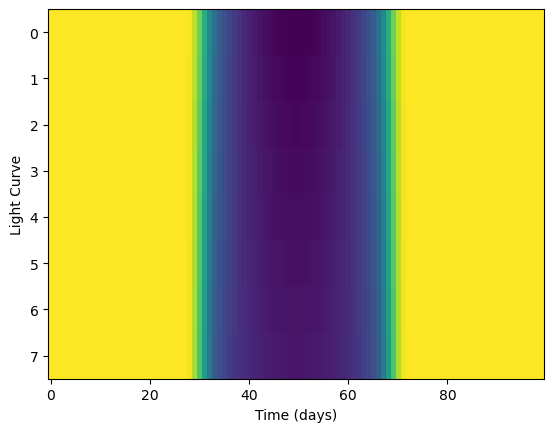

In [151]:
# First we must tell JAX which parameters of the function we want to vary for each light curve
# and which we want to be shared between light curves
transit_light_curve_vmap = jax.vmap(
    # First argument is the function to vectorise
    transit_light_curve, 
    
    # Specify which parameters to share and which to vary for each light curve
    in_axes=(
        {
        # If a parameter is to be shared across each light curve then it should be set to None
        "T0":None, "P":None, "a":None, "b":None,

        # Parameters which vary in wavelength are given the dimension of the array to expand along
        # In this case we are expanding from 0D arrays to 1D arrays so this must be 0
        "rho":0, "u1":0, "u2":0, "Foot":0, "Tgrad":0
        },
        # Also must specify that we will share the time array (the second function parameter)
        # between light curves
         None,  
    ),
    
    # Specify the output dimension to expand along, this will default to 0 anyway
    # Will output extra flux values for each light curve as additional rows
    out_axes = 0,
)

N_l = 8

# Now we define our 2D transit parameters, let's just assume everything is constant in wavelength
mfp_2D = {
    "T0":0.,                         # Central transit time
    "P":3.4,                         # Period (days)
    "a":8.,                          # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1*np.ones(N_l),          # Radius ratio rho aka Rp/R*
    "b":0.5,                       # Impact parameter
    "u1":np.linspace(0.7, 0.4, N_l), # First quadratic limb darkening coefficient
    "u2":np.linspace(0.1, 0.2, N_l), # Second quadratic limb darkening coefficient
    "Foot":1.*np.ones(N_l),          # Baseline flux out of transit
    "Tgrad":0.*np.ones(N_l)          # Gradient in baseline flux (days^-1)
}

# Call our new vmap of transit_light_curve to simultaneously compute light curves for all wavelengths
transit_model_2D = transit_light_curve_vmap(mfp_2D, x_t)

# Plot the data on the left and the multiwavelength model on the right
plt.imshow(transit_model_2D, aspect = 'auto')
plt.xlabel("Time (days)")
plt.ylabel("Light Curve")
plt.show()

The form of a mean function with ``luas.GP`` is ``f(par, x_l, x_t)`` where ``par`` is a PyTree, ``x_l`` is a JAXArray of inputs that lie along the wavelength/vertical dimension of the data (e.g. an array of wavelength values) and ``x_t`` is a JAXArray of inputs that lie along the time/horizontal dimension (e.g. an array of timestamps). Our transit model does not require wavelength values to be computed but we still write our wrapper function to be of this form.

Note our ``jax.vmap`` function specifies exactly the keys that must be in the input PyTree for ``transit_light_curve_vmap`` so we also filter only these parameters to be input into the ``transit_light_curve_vmap`` function

Below is a simple mean function which is compatible with ``luas``. You can also use ``luas.exoplanet.transit_2D`` although note that this fits for transit depth instead of radius ratio

In [152]:
from luas.exoplanet import ld_to_kipping, ld_from_kipping

def transit_2D(p, x_l, x_t):
    
    # vmap requires that we only input the parameters which have been explicitly defined how they vectorise
    transit_params = ["T0", "P", "a", "rho", "b", "Foot", "Tgrad"]
    mfp = {k:p[k] for k in transit_params}
    
    # Calculate limb darkening coefficients from the Kipping (2013) parameterisation.
    mfp["u1"], mfp["u2"] = ld_from_kipping(p["q1"], p["q2"])
    
    # Use the vmap of transit_light_curve to calculate a 2D array of shape (M, N) of flux values
    # For M wavelengths and N time points.
    return transit_light_curve_vmap(mfp, x_t)

# Let's define a wavelength range of our data, this isn't actually used by our mean function
# but we will use it for defining correlation in wavelength
N_l = 8
x_l = np.linspace(4000, 7000, N_l)

# Switch to Kipping parameterisation
if "u1" in mfp_2D:
    mfp_2D["q1"], mfp_2D["q2"] = ld_to_kipping(mfp_2D["u1"], mfp_2D["u2"])
    del mfp_2D["u1"]
    del mfp_2D["u2"]

M = transit_2D(mfp_2D, x_l, x_t)

Now that we have our mean function created, it's time to start building a kernel function. We will try keep things simple and use a squared exponential kernel for correlation in both time and wavelength, and white noise which varies in amplitude between light curves

$$
\begin{equation}
\mathbf{K}_{ij} = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right) + \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j} \delta_{t_i t_j}
\end{equation}
$$

This kernel contains a correlated noise component with height scale $h$, length scale in wavelength $l_\mathrm{\lambda}$ and length scale in time $l_t$. There is also a white noise term which can have different white noise amplitudes at different wavelengths.

We will need to write this kernel as separate wavelength and time kernel functions multiplied together satisfying:
$$
\begin{equation}
\text{K}(\Delta \lambda, \Delta t) = \text{K}_{l}(\Delta \lambda) \otimes \text{K}_{t}(\Delta t) + \text{S}_{l}(\Delta \lambda) \otimes \text{S}_{t}(\Delta t)
\end{equation}
$$

We can do this by choosing the equations below for our kernel functions which generate each component matrix. Note that for numerical stability reasons it's important that the $S_l$ and $S_t$ matrices are well-conditioned while $K_l$ and $K_t$ do not need to be well-conditioned and in fact don't even need to be invertible (they still must be positive semi-definite and symmetric)
$$
\begin{equation}
    \text{K}_l(\lambda_i, \lambda_j) = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) 
\end{equation}
$$

$$
\begin{equation}
    \text{K}_t(t_i, t_j) = \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right)
\end{equation}
$$

$$
\begin{equation}
    \text{S}_l(\lambda_i, \lambda_j) = \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j}
\end{equation}
$$

$$
\begin{equation}
    \text{S}_t(t_i, t_j) = \delta_{t_i t_j}
\end{equation}
$$

In [189]:
from luas import kernels
from luas import LuasKernel

# We implement each of these kernel functions below using the luas.kernels module
# for an implementation of the squared exponential kernel

def Kl_fn(hp, x_l1, x_l2, wn = True):
    Kl = jnp.exp(2*hp["log_h"])*kernels.squared_exp(x_l1, x_l2, jnp.exp(hp["log_l_l"]))
    return Kl

def Kt_fn(hp, x_t1, x_t2, wn = True):
    return kernels.squared_exp(x_t1, x_t2, jnp.exp(hp["log_l_t"]))

# For both the Sl and St functions we set a decomp attribute to "diag" because they produce diagonal matrices
# This speeds up the log likelihood calculations as it tells luas these matrices are easy to eigendecompose
# But don't do this for the Kl and Kt functions even if they produce diagonal matrices unless you know what you are doing
# This is because you are telling luas that the transformations of Kl and Kt are diagonal, not Kl and Kt themselves

def Sl_fn(hp, x_l1, x_l2, wn = True):
    Sl = jnp.zeros((x_l1.shape[-1], x_l2.shape[-1]))
    if wn:
        Sl += jnp.diag(jnp.exp(2*hp["log_sigma"]))

    return Sl
Sl_fn.decomp = "diag" # Sl is a diagonal matrix

def St_fn(p, x_t1, x_t2, wn = True):
    return jnp.eye(x_t1.shape[-1])
St_fn.decomp = "diag" # St is a diagonal matrix

# Build a LuasKernel object using these component kernel functions
# The full covariance matrix applied to the data will be K = Kl KRON Kt + Sl KRON St
kernel = LuasKernel(Kl = Kl_fn, Kt = Kt_fn, Sl = Sl_fn, St = St_fn,
                    
                    # Can select whether to use previously calculated eigendecompositions when running MCMC
                    # Performs an additional check in each step to see if each component covariance matrix has changed since last step
                    # Useful when doing blocked Gibbs or if fixing some hyperparameters
                    use_stored_values = True, 
                   )

The ``LuasKernel.visualise_covariance_matrix`` method should be a useful way of visualising each of the four component matrices and ensure everything you have written looks right

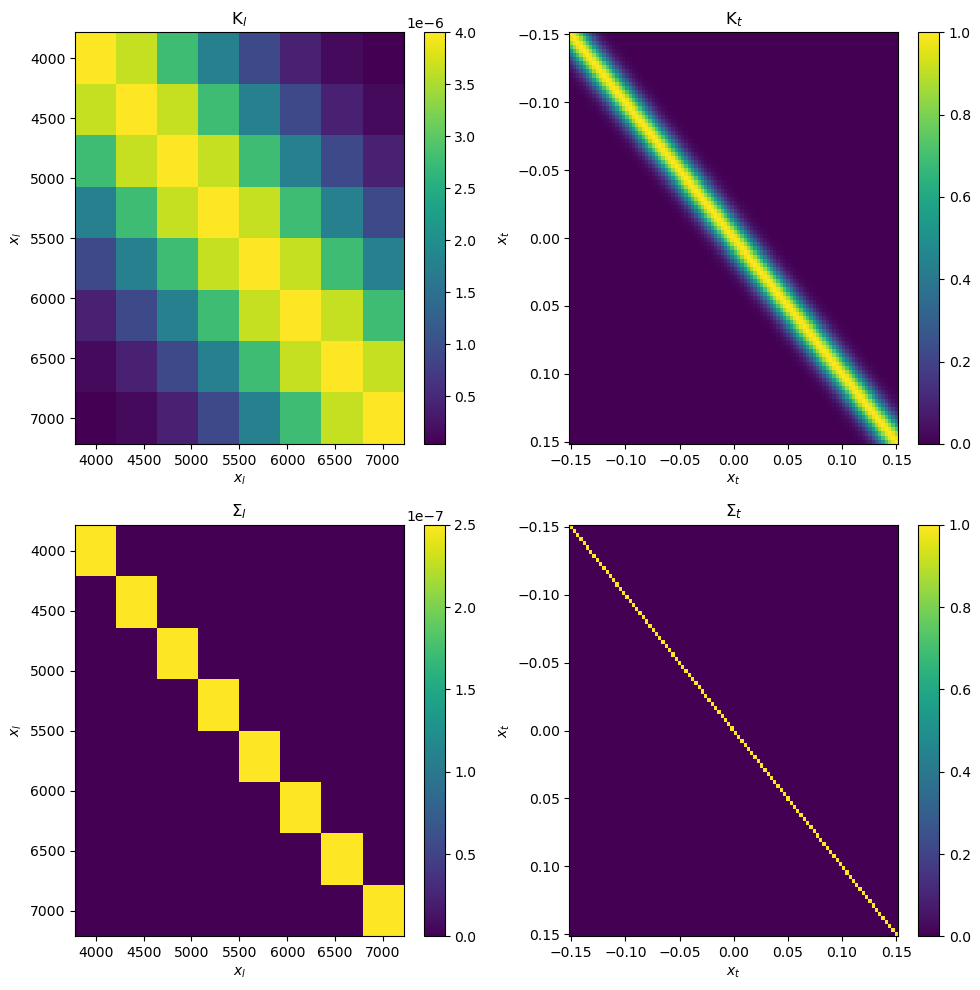

In [191]:
hp = {
    "log_h":np.log(2e-3),
    "log_l_l":np.log(1000.),
    "log_l_t":np.log(0.011),
    "log_sigma":np.log(5e-4)*np.ones(N_l),
}

kernel.visualise_covariance_matrix(hp, x_l, x_t);

Take a random noise draw from this covariance matrix. Try playing around with these values to see the effect varying each parameter has on the noise generated.

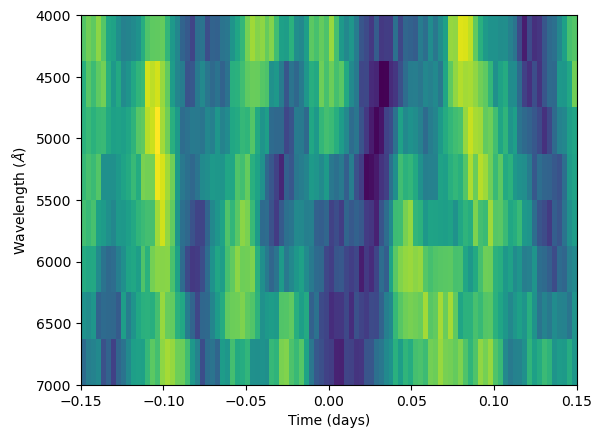

In [192]:
hp = {"log_h":np.log(2e-3), "log_l_l":np.log(1000.), "log_l_t":np.log(0.011),
      "log_sigma":np.log(5e-4)*np.ones(N_l),}

sim_noise = kernel.generate_noise(hp, x_l, x_t)

plt.imshow(sim_noise, aspect = 'auto', extent = [x_t[0], x_t[-1], x_l[-1], x_l[0]])
plt.xlabel("Time (days)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

Combining our light curves and noise model we can generate synthetic light curves contaminated by systematics correlated in time and wavelength

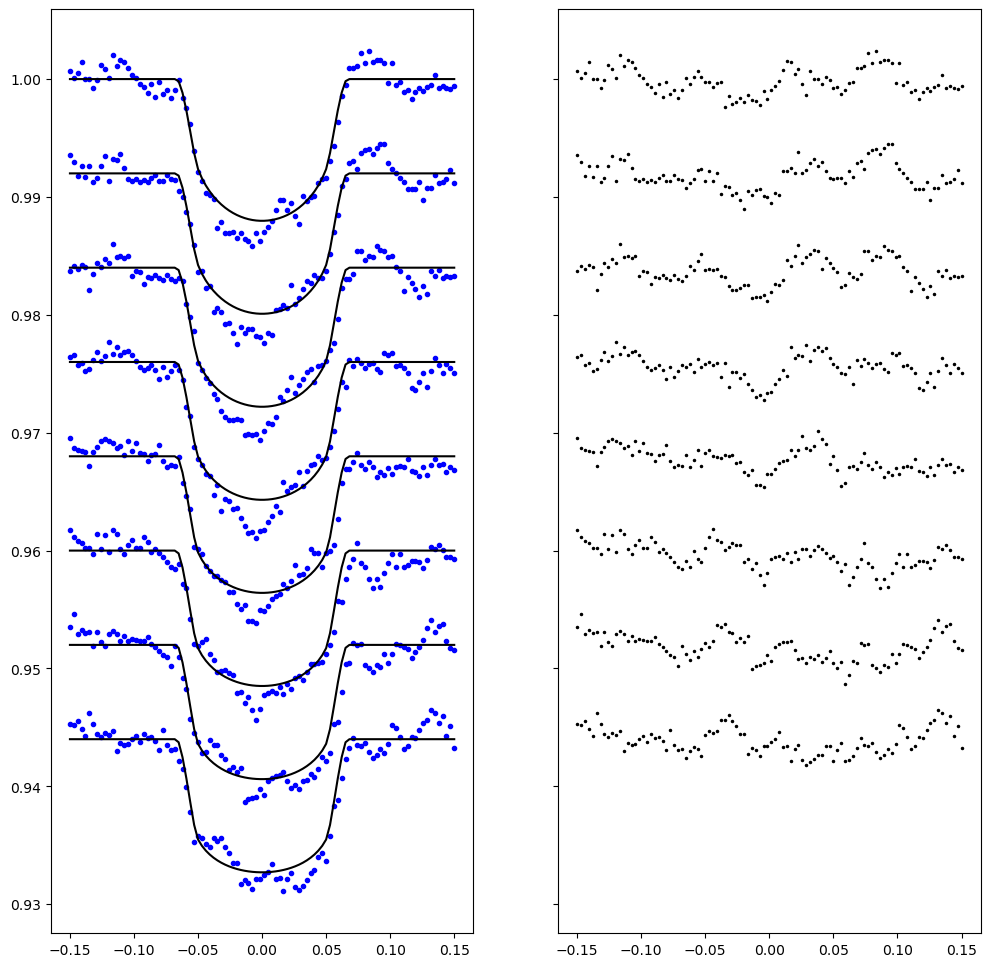

In [193]:
def plot_lightcurves(x_t, M, Y, sep = 0.008):
    N_l = x_l.shape[-1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12), sharey = True)
    for i in range(N_l):
        ax1.plot(x_t, Y[i, :] + np.arange(0, -sep*N_l, -sep)[i], 'bo', ms = 3)
        
        ax1.plot(x_t, M[i, :] + np.arange(0, -sep*N_l, -sep)[i], 'k-', ms = 3)
        ax2.plot(x_t, Y[i, :] - M[i, :] + np.arange(1, 1-sep*N_l, -sep)[i], 'k.', ms = 3)

u1_sim, u2_sim = np.linspace(0.7, 0.4, N_l), np.linspace(0.1, 0.2, N_l)
q1_sim, q2_sim = ld_to_kipping(u1_sim, u2_sim)

p_sim = {
    "T0":0.*np.ones(1),                         # Central transit time
    "P":3.4*np.ones(1),                         # Period (days)
    "a":8.*np.ones(1),                          # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1*np.ones(N_l),          # Radius ratio rho aka Rp/R*
    "b":0.5*np.ones(1),                       # Impact parameter
    "q1":q1_sim, # First quadratic limb darkening coefficient
    "q2":q2_sim, # Second quadratic limb darkening coefficient
    "Foot":1.*np.ones(N_l),          # Baseline flux out of transit
    "Tgrad":0.*np.ones(N_l),          # Gradient in baseline flux (days^-1)
    "log_h":np.log(1e-3)*np.ones(1),
    "log_l_l":np.log(1000.)*np.ones(1),
    "log_l_t":np.log(0.011)*np.ones(1),
    "log_sigma":np.log(5e-4)*np.ones(N_l),
}

transit_signal = transit_2D(p_sim, x_l, x_t)
sim_noise = kernel.generate_noise(p_sim, x_l, x_t)
Y = transit_signal*(1 + sim_noise)

plot_lightcurves(x_t, transit_signal, Y)

We may also want to define a logPrior function. While PyMC can also be used to define priors on parameters, it can be useful to let ``luas.GP`` handle non-uniform priors when it comes to MCMC tuning.

The ``logPrior`` function may only take the PyTree of mean function parameters and hyperparameters as input

In [196]:
a_mean = p_sim["a"]
a_std = 0.1
b_mean = p_sim["b"]
b_std = 0.01
u1_mean = u1_sim
u1_std = 0.1
u2_mean = u2_sim
u2_std = 0.1

def logPrior(p):
    logPrior = -0.5*((p["a"] - a_mean)/a_std)**2
    logPrior += -0.5*((p["b"] - b_mean)/b_std)**2
    
    u1, u2 = ld_from_kipping(p["q1"], p["q2"])
    u1_priors = -0.5*((u1 - u1_mean)/u1_std)**2
    u2_priors = -0.5*((u2 - u2_mean)/u2_std)**2
    
    logPrior += u1_priors.sum() + u2_priors.sum()

    return logPrior.sum()

print("Log prior at simulated values:", logPrior(p_sim))

Log prior at simulated values: -1.0400021699691074e-30


We now have enough to define our ``luas.GP`` object and use it to try recover the original transmission signal injected into the correlated noise

Starting log posterior value: 4801.297814193514


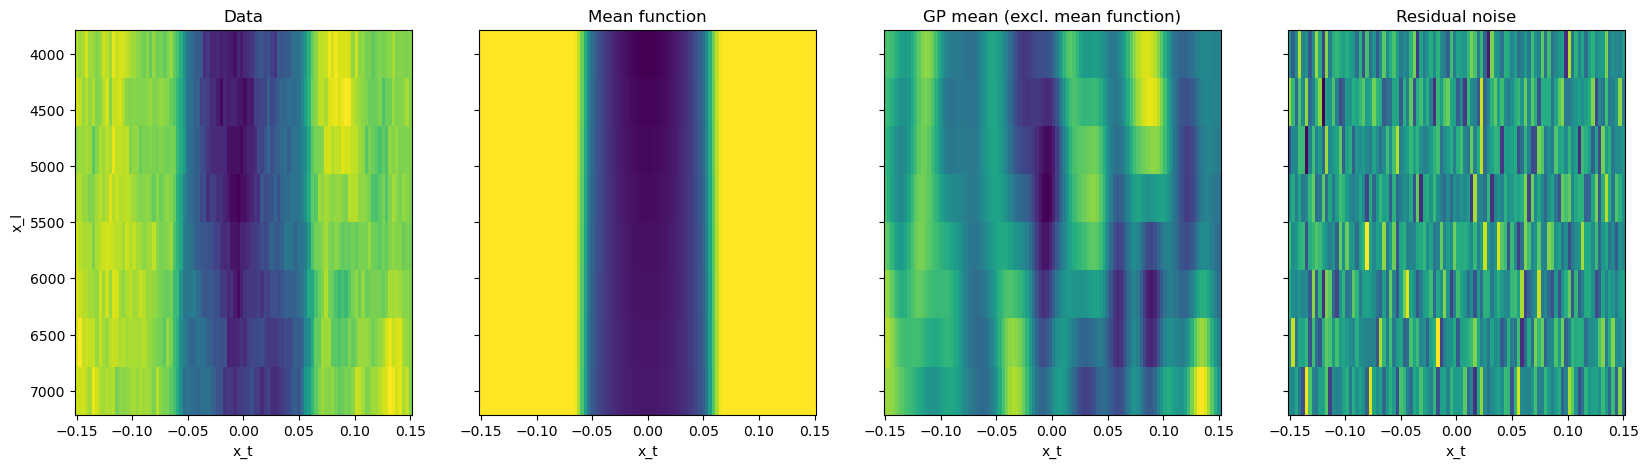

In [198]:
from luas import GP
from copy import deepcopy

# Initialise our GP object
# Make sure to include the mean function and log prior function if you're using them
gp = GP(kernel, x_l, x_t, mf = transit_2D, logPrior = logPrior)

# Initialise our starting values as the true simulated values
p_initial = deepcopy(p_sim)

# Convenient function for plotting the data and the GP fit to the data
gp.plot(p_initial, Y)
print("Starting log posterior value:", gp.logP(p_initial, Y))

Now let's begin using PyMC to perform a best-fit. We've already set the true simulated values as our initial values so we should already be close to the optimal log posterior value but for real data this won't always be the case. Similar to the approach in Fortune et al. (2024) we will not be performing any white light curve analysis but instead will be joint-fitting all spectroscopic light curves simultaneously

In [200]:
import pymc as pm
from luas.pymc_ext import LuasPyMC

# Let's define some bounds
min_log_l_l = np.log(np.diff(x_l).min())
max_log_l_l = np.log(50*(x_l[-1] - x_l[0]))

param_bounds = {
                "q1":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "q2":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "rho":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "log_h":   [np.log(1e-6)*np.ones(1), np.log(1e-2)*np.ones(1)],
                "log_l_l": [min_log_l_l*np.ones(1), max_log_l_l*np.ones(1)],
                "log_sigma":[np.log(1e-6)*np.ones(N_l), np.log(1e-2)*np.ones(N_l)],
               }


def transit_model(p_fixed, Y):
    
    with pm.Model() as model:

        # Makes of copy of any parameters to be kept fixed during sampling
        var_dict = deepcopy(p_fixed)
        
        # Specify the parameters we've given bounds for
        var_dict["rho"] = pm.Uniform('rho', lower=param_bounds["rho"][0],   upper=param_bounds["rho"][1], shape=N_l)
        var_dict["q1"] = pm.Uniform('q1', lower=param_bounds["q1"][0],   upper=param_bounds["q1"][1], shape=N_l)
        var_dict["q2"] = pm.Uniform('q2', lower=param_bounds["q2"][0],   upper=param_bounds["q2"][1], shape=N_l)
        var_dict["log_h"] =   pm.Uniform("log_h", lower=param_bounds["log_h"][0], upper=param_bounds["log_h"][1], shape=1)
        var_dict["log_l_l"] = pm.Uniform("log_l_l", lower = param_bounds["log_l_l"][0], upper = param_bounds["log_l_l"][1],
                                         shape=1)
        var_dict["log_sigma"] = pm.Uniform('log_sigma', lower=param_bounds["log_sigma"][0], upper=param_bounds["log_sigma"][1],
                                           shape=N_l)
        
        # Specify the unbounded parameters
        var_dict["T0"] = pm.Flat('T0', shape=1)
        var_dict["a"] = pm.Flat('a', shape=1)
        var_dict["b"] = pm.Flat('b', shape=1)
        var_dict["Foot"] = pm.Flat('Foot', shape=N_l)
        var_dict["Tgrad"] = pm.Flat('Tgrad', shape=N_l)
        var_dict["log_l_t"] = pm.Flat('log_l_t', shape=1)

        LuasPyMC("log_like", gp = gp, var_dict = var_dict, Y = Y)
        
    return model, var_dict

# Initialise our model, p_initial will specify any fixed values like the period P
model, var_dict = transit_model(p_initial, Y)

Now we are all set up to start performing a best-fit using ``PyMC``

In [202]:
# PyMC requires the dictionary of starting values to only include variables in the model
# So we must remove the period parameter P as we keep it fixed
p_pymc = deepcopy(p_initial)
del p_pymc["P"]

# Use PyMC's maximum posteriori optimisation method
map_estimate = pm.find_MAP(
    model = model,
    include_transformed = False,
    start = p_pymc,
    maxeval = 30000,
)

# Create a new dictionary of optimised values which includes our fixed parameters
p_opt = deepcopy(p_initial)
p_opt.update(map_estimate)

print("Starting log posterior value:", gp.logP(p_initial, Y))
print("New optimised log posterior value:", gp.logP(p_opt, Y))


Starting log posterior value: 4801.297814193514
New optimised log posterior value: 4819.77444667539


Although this probably won't be needed for the simulated data and will likely clip no data points, ``luas.GP`` comes with a ``sigma_clip`` method which performs 2D Gaussian process regression and can clip outliers that deviate from a given significance value and replace them with the GP predictive mean at those locations (note we need to maintain a complete grid structure and cannot remove these data points)

Number of outliers clipped =  0


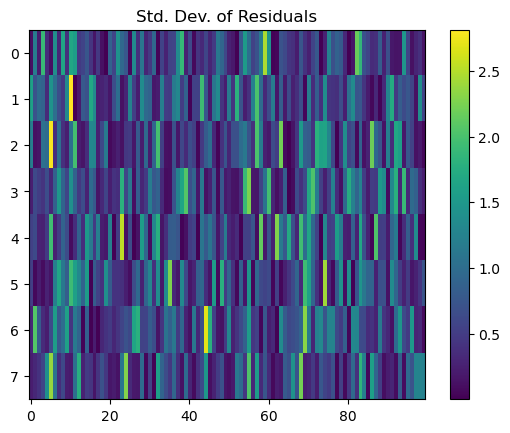

In [203]:
# This function will return a JAXArray of the same shape as Y
# but with outliers replaced with interpolated values
Y_clean = gp.sigma_clip(p_opt, # Make sure to perform sigma clipping using a good fit to the data
                        Y,     # Observations JAXArray
                        5.     # Significance level in standard deviations to clip at
                       )

For MCMC tuning with large numbers of parameters it can be very helpful to use the Laplace approximation to select a good choice of tuning matrix or "mass matrix" for No U-Turn Sampling. This can often return quite accurate approximations of the covariance matrix of the posterior especially when the data is clean enough to constrain most of the parameters.

Note that we use the ``gp.laplace_approx_with_bounds`` method instead of ``gp.laplace_approx`` because we have bounds on some of our parameters which means ``PyMC`` will perform a transformation on these parameters we would like our Laplace approximation to take account of. See the ``gp.laplace_approx_with_bounds`` documentation for more details.

In [205]:
# Returns the covariance matrix returned by the Laplace approximation
# Also returns a list of parameters which is the order the array is in
# This matches the way jax.flatten_util.ravel_pytree will sort the parameter PyTree into
cov_mat, ordered_param_list = gp.laplace_approx_with_bounds(
    p_opt,               # Make sure to use best-fit values
    Y_clean,             # The observations being fit
    param_bounds,        # Specify the same bounds that will be used for the MCMC
    fixed_vars = ["P"],  # Make sure to specify fixed parameters as otherwise they are marginalised over
    return_array = True, # May optionally return a nested PyTree if set to False which can be more readable
    regularise = True,   # Often necessary to regularise values that return negative covariance
    large = False        # For large data sets with many parameters setting this to True is more memory efficient
)

No regularisation needed to remove negative values along diagonal of covariance matrix.


Build our model again using the same parameters being varied and sample all parameters using NUTS. Note that ``PyMC`` has far more options for sampling here and can easily do blocked Gibbs sampling with multiple NUTS steps or you can intermix NUTS sampling with other methods such as slice sample, etc.

In [206]:
# Initialise our PyMC model
model, var_dict = transit_model(p_opt, Y_clean)

# The NUTS step takes as input the variables created when initialising the model
# We also sort these variables in the same order our Laplace approximated covariance matrix is in
NUTS_model_vars = [var_dict[par] for par in ordered_param_list]
NUTS_step = pm.NUTS(NUTS_model_vars, scaling = cov_mat, is_cov = True, model = model)

# Begin MCMC sampling
idata = pm.sample(
    model = model,
    step = NUTS_step,
    initvals = map_estimate,
    draws = 1000,
    tune = 1000,
    chains = 2,
    cores = 1, # This will probably fail if not set to 1 as I don't think PyMC can parallelise JAX functions
)

INFO:pymc:Sequential sampling (2 chains in 1 job)
INFO:pymc:NUTS: [Foot, T0, Tgrad, a, b, log_h, log_l_l, log_l_t, log_sigma, q1, q2, rho]


INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 330 seconds.


Print a summary of the samples using ``arviz``

In [210]:
az.summary(idata, round_to = 4)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
T0[0]         0.0002  0.0004 -0.0006   0.0010     0.0000   0.0000  3123.0680   
a[0]          7.9785  0.0625  7.8594   8.0906     0.0012   0.0008  2922.0566   
b[0]          0.4996  0.0092  0.4825   0.5164     0.0002   0.0001  3635.7140   
Foot[0]       1.0001  0.0004  0.9993   1.0008     0.0000   0.0000  2195.3741   
Foot[1]       1.0000  0.0004  0.9993   1.0007     0.0000   0.0000  2111.0152   
Foot[2]       0.9997  0.0004  0.9990   1.0004     0.0000   0.0000  1942.6729   
Foot[3]       0.9996  0.0004  0.9990   1.0004     0.0000   0.0000  1846.4350   
Foot[4]       0.9996  0.0004  0.9989   1.0003     0.0000   0.0000  1685.0479   
Foot[5]       0.9995  0.0004  0.9987   1.0002     0.0000   0.0000  1619.6989   
Foot[6]       0.9999  0.0004  0.9991   1.0006     0.0000   0.0000  1577.1649   
Foot[7]       1.0000  0.0004  0.9992   1.0008     0.0000   0.0000  1661.2533   
Tgrad[0]     -0.0001  0.0001 -0.0003   0.0002     0.0000   0.0000  2375.5134   
Tgrad[1]     -0.0000  0.0001 -0.0003   0.0003     0.0000   0.0000  2403.9787   
Tgrad[2]     -0.0001  0.0001 -0.0003   0.0002     0.0000   0.0000  2449.1843   
Tgrad[3]     -0.0001  0.0001 -0.0004   0.0001     0.0000   0.0000  2464.5100   
Tgrad[4]     -0.0003  0.0001 -0.0006  -0.0000     0.0000   0.0000  2513.5222   
Tgrad[5]     -0.0003  0.0001 -0.0006  -0.0000     0.0000   0.0000  2243.1678   
Tgrad[6]     -0.0002  0.0001 -0.0005   0.0000     0.0000   0.0000  2053.6044   
Tgrad[7]     -0.0001  0.0001 -0.0004   0.0001     0.0000   0.0000  1960.6102   
log_l_t[0]   -4.4854  0.0692 -4.6138  -4.3556     0.0015   0.0011  2151.6546   
rho[0]        0.1028  0.0030  0.0972   0.1082     0.0001   0.0000  1981.2519   
rho[1]        0.1025  0.0030  0.0962   0.1077     0.0001   0.0001  1741.0153   
rho[2]        0.1003  0.0031  0.0944   0.1065     0.0001   0.0001  1442.5998   
rho[3]        0.1002  0.0031  0.0947   0.1063     0.0001   0.0001  1384.0538   
rho[4]        0.0985  0.0031  0.0926   0.1041     0.0001   0.0001  1303.0043   
rho[5]        0.0979  0.0032  0.0917   0.1034     0.0001   0.0001  1390.3870   
rho[6]        0.1005  0.0032  0.0938   0.1057     0.0001   0.0001  1514.3354   
rho[7]        0.1008  0.0032  0.0950   0.1068     0.0001   0.0001  1484.7811   
q1[0]         0.6231  0.1245  0.3764   0.8521     0.0033   0.0025  1452.2240   
q1[1]         0.6151  0.1131  0.3921   0.8257     0.0042   0.0034   790.6619   
q1[2]         0.6297  0.1135  0.4189   0.8459     0.0046   0.0036   627.9395   
q1[3]         0.5782  0.1169  0.3755   0.7895     0.0063   0.0053   511.7459   
q1[4]         0.4120  0.1003  0.2341   0.5990     0.0035   0.0027   914.5613   
q1[5]         0.4634  0.1006  0.2753   0.6452     0.0024   0.0017  1867.4312   
q1[6]         0.2958  0.0861  0.1516   0.4668     0.0018   0.0013  2397.8583   
q1[7]         0.3884  0.1129  0.1802   0.5905     0.0024   0.0018  2338.9100   
q2[0]         0.4341  0.0522  0.3352   0.5318     0.0010   0.0008  2690.5970   
q2[1]         0.4363  0.0514  0.3427   0.5337     0.0009   0.0006  3391.7854   
q2[2]         0.4064  0.0506  0.3153   0.5051     0.0009   0.0007  3089.6865   
q2[3]         0.3921  0.0522  0.2898   0.4842     0.0012   0.0009  1894.3651   
q2[4]         0.4043  0.0615  0.2880   0.5188     0.0012   0.0009  2643.9465   
q2[5]         0.3766  0.0556  0.2777   0.4844     0.0011   0.0008  2517.3539   
q2[6]         0.3650  0.0738  0.2397   0.5113     0.0018   0.0013  1824.4153   
q2[7]         0.3358  0.0619  0.2109   0.4458     0.0011   0.0009  3279.3614   
log_h[0]     -6.8610  0.1231 -7.0888  -6.6389     0.0034   0.0024  1411.3081   
log_l_l[0]    7.0264  0.0978  6.8398   7.1978     0.0023   0.0016  1829.5803   
log_sigma[0] -7.5819  0.0840 -7.7374  -7.4284     0.0014   0.0010  3785.2819   
log_sigma[1] -7.5035  0.0794 -7.6473  -7.3503     0.0014   0.0010  3424.6419   
log_sigma[2] -7.6173  0.0777 -7.7605  -7.4674     0.0014   0.0010  3256.8552   
log_sigma[3] -7.

The ``arviz.plot_trace`` function can be very useful for visualising the marginal posterior distributions of the different parameters as well as to examine the chains and diagnose any possible convergence issues.

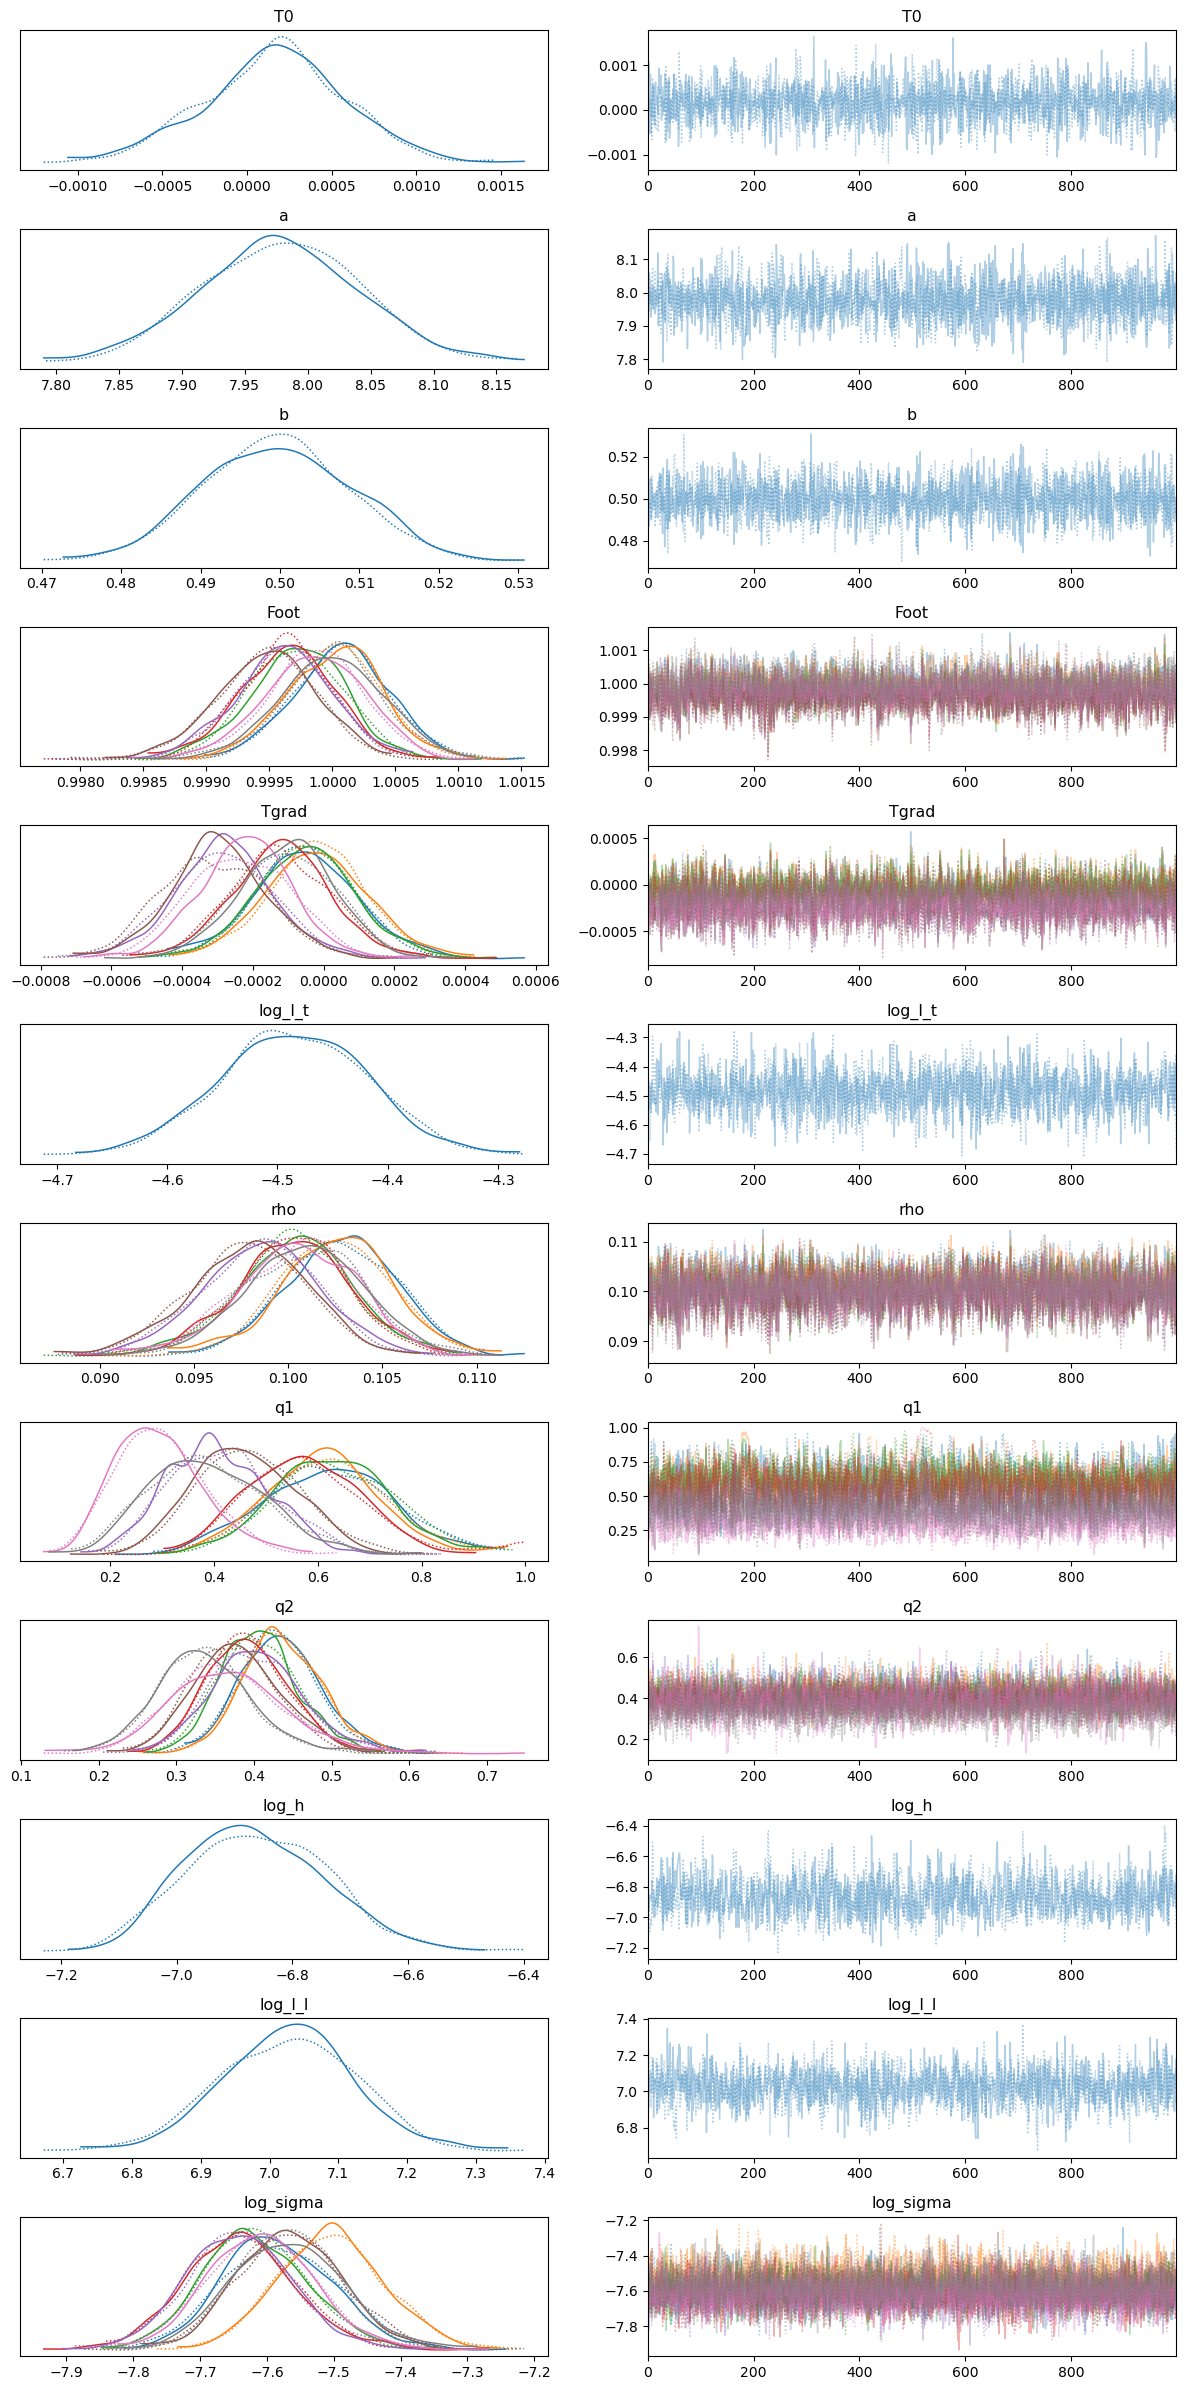

In [211]:
trace_plot = az.plot_trace(idata, divergences = None)
plt.tight_layout()

``corner`` is a great module to use for generating corner plots. Unfortunately when fitting many light curves the number of parameters can make visualising the full corner plot quite unwieldly but we can always just plot subsets of parameters to show

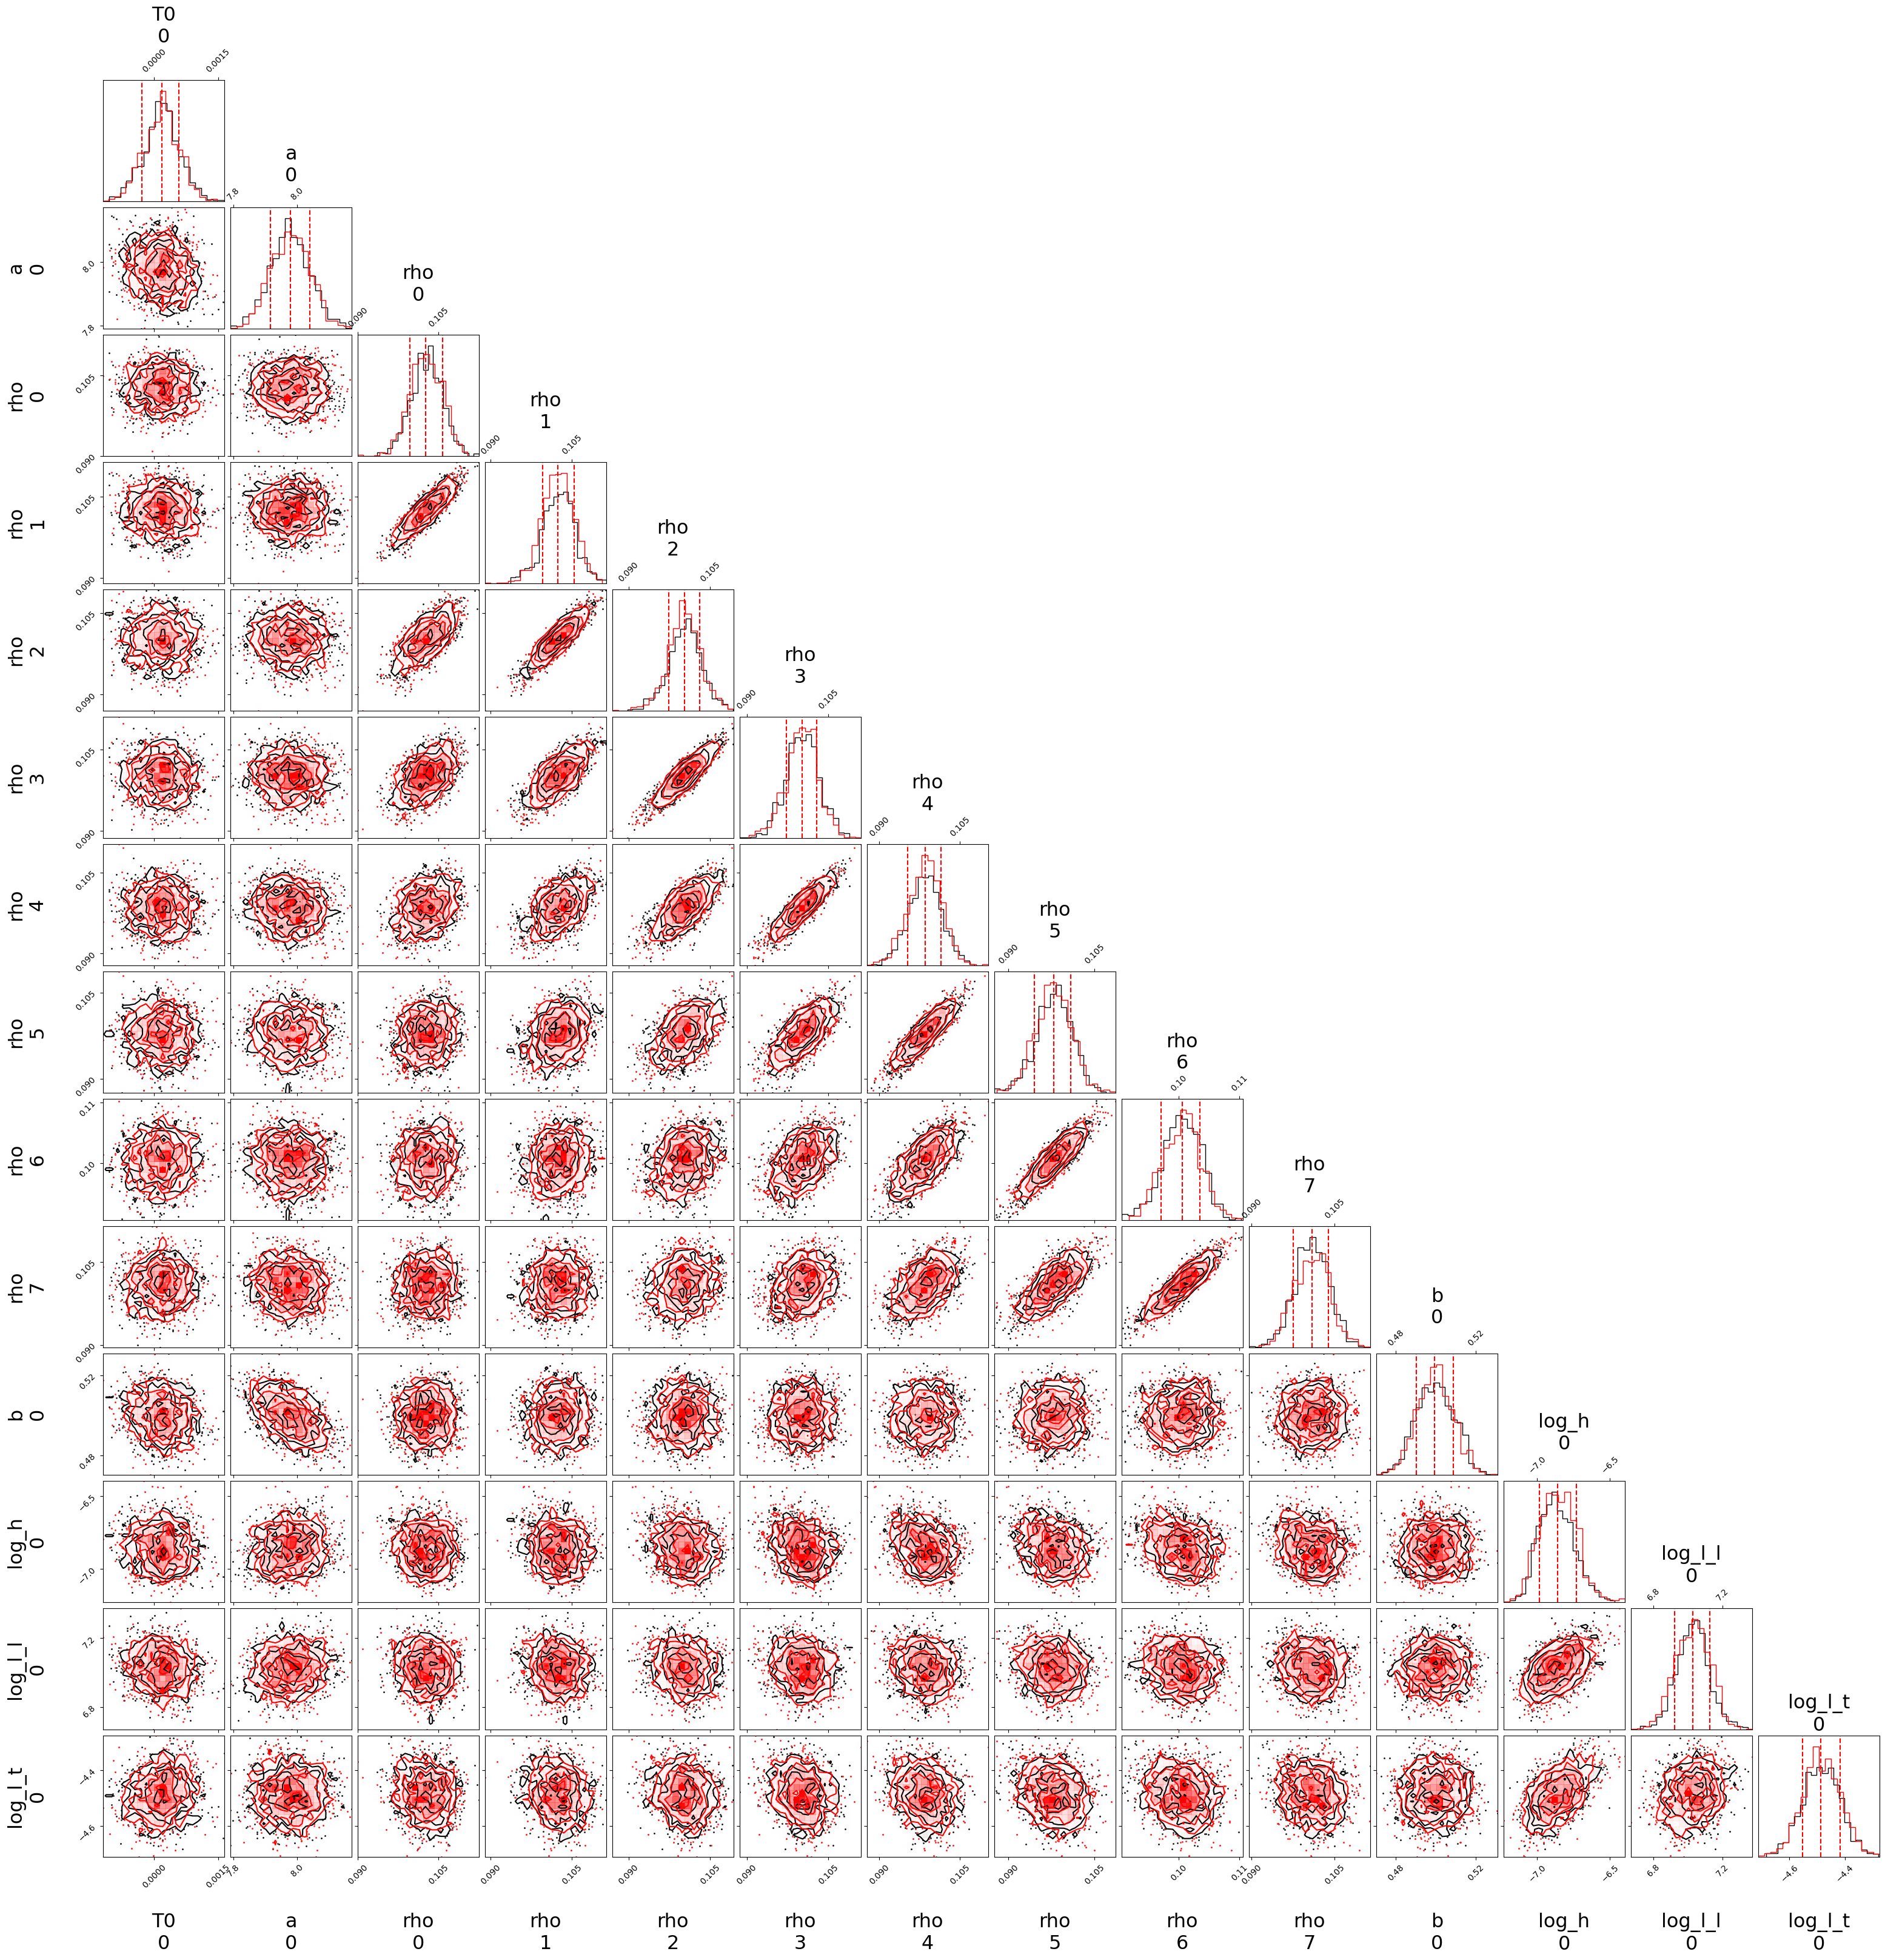

In [212]:
from corner import corner

idata_corner1 = idata.sel(chain=[0])
idata_corner2 = idata.sel(chain=[1])

params = ["T0", "a", "rho", "b", "log_h", "log_l_l", "log_l_t"]

fig1 = corner(idata_corner1, smooth = 0.4, var_names = params, data_kwargs = {"alpha":1.})
fig2 = corner(idata_corner2, quantiles=[0.16, 0.5, 0.84], title_fmt = None, title_kwargs={"fontsize": 23}, label_kwargs={"fontsize": 23}, show_titles=True,
                     smooth = 0.4, color = "r", fig = fig1, top_ticks = True, max_n_ticks = 2, labelpad = 0.16, var_names = params, data_kwargs = {"alpha":1.})